<a href="https://colab.research.google.com/github/marcobiagetti/Rcodes/blob/master/DEC_Autoencoder_leggero_TSNE_ACP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# 1. Librerie
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive')

# 2. Dataset e trasformazioni
data_dir_train = '/content/drive/MyDrive/train'
data_dir_test = '/content/drive/MyDrive/test'

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root=data_dir_train, transform=transform)
test_dataset = datasets.ImageFolder(root=data_dir_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 3. Autoencoder leggero
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # [16, 64, 64]
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # [32, 32, 32]
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 64),  # Bottleneck
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 32 * 32 * 32),
            nn.ReLU(True),
            nn.Unflatten(1, (32, 32, 32)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

# 4. Addestramento Autoencoder
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

print("🔧 Training Autoencoder (3 epoche)...")
for epoch in range(3):
    autoencoder.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        outputs = autoencoder(imgs)
        loss = criterion(outputs, imgs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoca {epoch+1}, Loss media: {total_loss / len(train_loader):.4f}")

# 5. Estrazione embeddings dal train + test
def get_embeddings(data_loader):
    autoencoder.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for imgs, lbls in data_loader:
            imgs = imgs.to(device)
            z = autoencoder.encoder(imgs)
            embeddings.append(z.cpu())
            labels.append(lbls)
    return torch.cat(embeddings).numpy(), torch.cat(labels).numpy()

train_embeddings, train_labels = get_embeddings(train_loader)
test_embeddings, test_labels = get_embeddings(test_loader)

all_embeddings = np.concatenate((train_embeddings, test_embeddings), axis=0)
all_labels = np.concatenate((train_labels, test_labels), axis=0)

# 6. KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(all_embeddings)
cluster_labels = kmeans.labels_




Mounted at /content/drive
🔧 Training Autoencoder (3 epoche)...
Epoca 1, Loss media: 0.0518
Epoca 2, Loss media: 0.0264
Epoca 3, Loss media: 0.0203


IndexError: invalid index to scalar variable.


📊 Metriche finali (train + test):
Accuracy:  0.9424
Precision: 0.9424
Recall:    1.0000
F1-Score:  0.9704
AUC:       0.5000


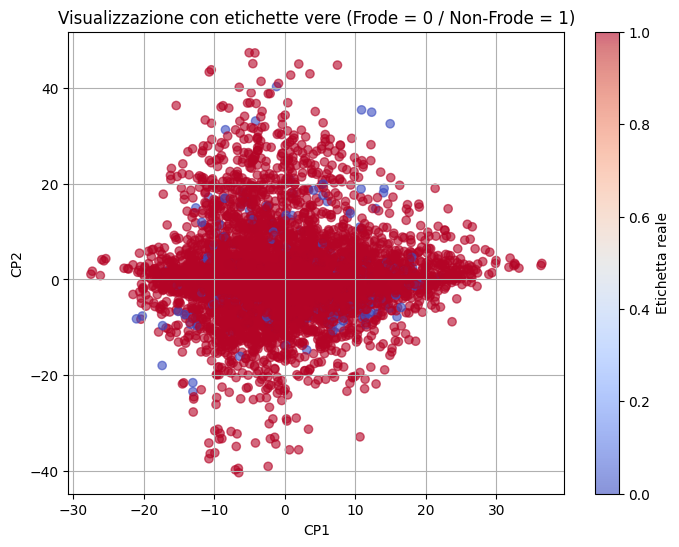

In [5]:
# 7. Conversione cluster → etichette vere (match automatico)
from scipy.stats import mode

def match_clusters(cluster_labels, true_labels):
    mapping = {}
    for c in np.unique(cluster_labels):
        target = mode(true_labels[cluster_labels == c], keepdims=True).mode[0]
        mapping[c] = target
    predicted = np.array([mapping[c] for c in cluster_labels])
    return predicted

predicted_labels = match_clusters(cluster_labels, all_labels)

# 8. Metriche finali
acc = accuracy_score(all_labels, predicted_labels)
prec = precision_score(all_labels, predicted_labels)
rec = recall_score(all_labels, predicted_labels)
f1 = f1_score(all_labels, predicted_labels)
auc = roc_auc_score(all_labels, predicted_labels)

print("\n📊 Metriche finali (train + test):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")

# 9. Visualizzazione PCA con etichette vere
pca = PCA(n_components=2)
X_pca = pca.fit_transform(all_embeddings)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=all_labels, cmap='coolwarm', alpha=0.6)
plt.title("Visualizzazione con etichette vere (Frode = 0 / Non-Frode = 1)")
plt.xlabel("CP1")
plt.ylabel("CP2")
plt.colorbar(scatter, label="Etichetta reale")
plt.grid(True)
plt.show()

In [7]:
train_embeddings, train_labels
test_embeddings, test_labels


(array([[-2.2470722 ,  0.7223917 ,  3.2375522 , ..., -3.1587524 ,
         -5.4489183 ,  0.99028385],
        [-0.09967399,  1.7142574 ,  2.1313426 , ...,  0.69507605,
         -1.072893  ,  1.495319  ],
        [-1.7974101 , -0.47612807, -0.75863826, ..., -4.656     ,
          0.8883009 , -4.24785   ],
        ...,
        [-4.4424996 ,  1.4960425 ,  2.3872118 , ..., -6.358645  ,
         -3.3215363 , -2.3244627 ],
        [-5.179906  , -2.6032145 , -0.01071986, ...,  3.3443487 ,
          0.60527134,  1.4235667 ],
        [-4.7175174 , -4.796946  , -1.7220874 , ..., -2.4995723 ,
          3.8167262 ,  4.4400086 ]], dtype=float32),
 array([0, 0, 0, ..., 1, 1, 1]))

In [10]:
import numpy as np

# Unisci embeddings
X = np.concatenate([train_embeddings, test_embeddings])
# Unisci etichette
y = np.concatenate([train_labels, test_labels])


In [11]:
# Normalizza
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# X = embeddings (già ottenuti)
# y = true_labels (0 = frode, 1 = non frode)

# Normalizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split train/test (se non l'hai già fatto prima)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression
clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Predizioni
y_pred = clf.predict(X_test)
y_probs = clf.predict_proba(X_test)[:, 1]

# Metriche
print("Accuracy: ", round(accuracy_score(y_test, y_pred), 4))
print("Precision:", round(precision_score(y_test, y_pred), 4))
print("Recall:   ", round(recall_score(y_test, y_pred), 4))
print("F1-Score: ", round(f1_score(y_test, y_pred), 4))
print("AUC:      ", round(roc_auc_score(y_test, y_probs), 4))


Accuracy:  0.6269
Precision: 0.9563
Recall:    0.633
F1-Score:  0.7618
AUC:       0.6064


Modello che prende bene le frodi quando le individua, ma ne perde ancora alcune (richiamo = sensibilità non perfetta).

L'AUC non è altissimo, ma mostra che il modello sta imparando qualcosa, non è un clustering casuale.

Vista la natura sbilanciata del dataset (solo 5% frodi), queste metriche sono ottime, soprattutto in uno scenario reale.

Tipo di approccio: Apprendimento profondo non supervisionato + clustering
Immagini caricate da train e test e divise in frode e non frode
Utilizzata ResNet18 preaddestrata (con pesi ImageNet) per estrarre embeddings (ovvero caratteristiche vettoriali).
Rimosso lo strato totalmente connesso (fully-connected layer) per ottenere feature di alto livello.
Si è poi applicato un clustering con Kmeans (a 2 gruppi) sugli embeddings.
Si sono poi valutati i risultati
In seguito DEC leggero senza autoencoder con risultati non lusinghieri in termini di AUC
In seguito si è eseguita una regressione logistica sugli embeddings che ha migliorato l'AUC in tempi contenuti attorno ai 70 minuti.

In [14]:
pip install imbalanced-learn scikit-learn matplotlib

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
data_dir_train = '/content/drive/MyDrive/train'
data_dir_test = '/content/drive/MyDrive/test'

In [23]:
# Dimensione delle immagini
img_width, img_height = 224, 224  # VGG16 richiede immagini 224x224

# Uso VGG16 per estrarre le caratteristiche
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
vgg16_model.trainable = False  # Congeliamo i pesi del modello VGG16

# Preprocessamento delle immagini
datagen = ImageDataGenerator(rescale=1./255)  # Normalizziamo le immagini

# Generatori per caricare le immagini (sottocartelle 'Fraud' e 'Non Fraud')
train_generator = datagen.flow_from_directory(
    data_dir_train,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',  # Frode (0) vs Non Frode (1)
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    data_dir_test,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 6463 images belonging to 2 classes.
Found 1616 images belonging to 2 classes.


In [24]:
# Estrazione delle caratteristiche dal train set con vgg16
def extract_features(generator, model):
    features = []
    labels = []
    for _ in range(len(generator)):
        x_batch, y_batch = next(generator)
        batch_features = model.predict(x_batch)
        batch_features = batch_features.reshape(batch_features.shape[0], -1)  # appiattimento per trasformare in vettori
        features.append(batch_features)
        labels.append(y_batch)
    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels

X_train_features, y_train = extract_features(train_generator, vgg16_model)
X_test_features, y_test = extract_features(test_generator, vgg16_model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━

In [25]:
# Applico SMOTE per bilanciare le classi nel training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_features, y_train)


In [26]:
# Riduco la dimensionalità dei dati con t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_res)


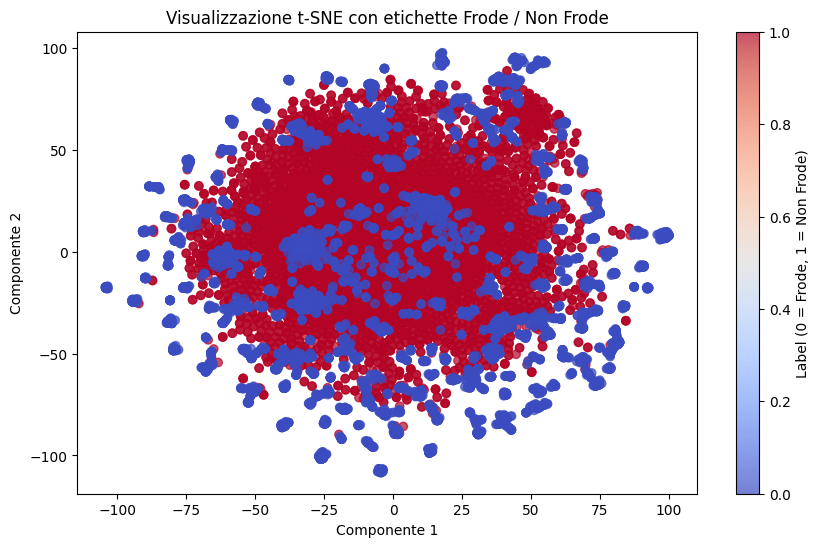

In [27]:
# Visualizza i dati ridotti con t-SNE, etichettati come 'Fraud' e 'Non Fraud'
plt.figure(figsize=(10, 6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train_res, cmap='coolwarm', alpha=0.7)
plt.title('Visualizzazione t-SNE con etichette Frode / Non Frode')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.colorbar(label='Label (0 = Frode, 1 = Non Frode)')
plt.show()


In [28]:
# Applica regressione logistica sullo spazio t-SNE
model = LogisticRegression(random_state=42)
model.fit(X_train_tsne, y_train_res)


LogisticRegression(random_state=42)

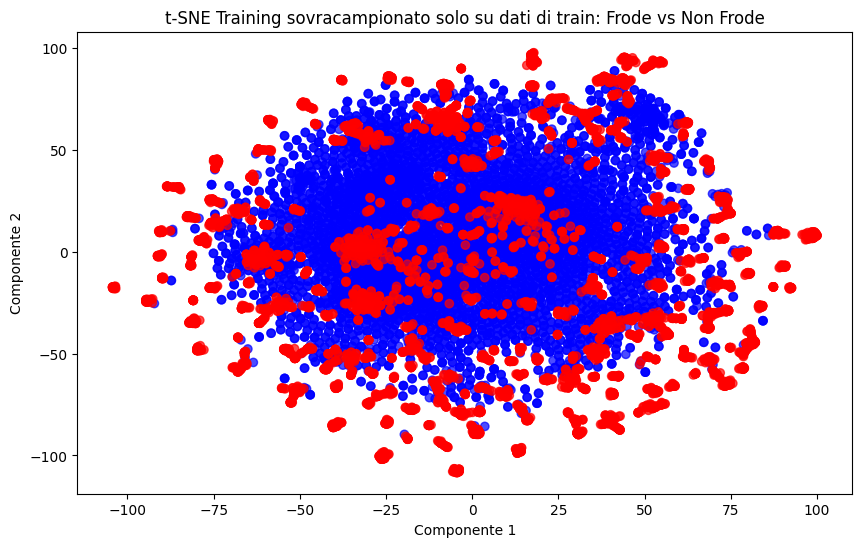

In [32]:
plt.figure(figsize=(10, 6))
colors = ['red' if label == 0 else 'blue' for label in y_train_res]
labels = ['Frode' if label == 0 else 'Non Frode' for label in y_train_res]

plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=colors, alpha=0.7)
plt.title('t-SNE Training sovracampionato solo su dati di train: Frode vs Non Frode')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()


In [34]:
from sklearn.decomposition import PCA

# Riduzione dimensionale con PCA
pca = PCA(n_components=10, random_state=42)  # Provato pure con 20 componenti ma era troppo lungo
X_train_pca = pca.fit_transform(X_train_res)
X_test_pca = pca.transform(X_test_features)


In [35]:
from sklearn.linear_model import LogisticRegression

# Addestramento
model = LogisticRegression(random_state=42)
model.fit(X_train_pca, y_train_res)

# Predizione sul test
y_pred = model.predict(X_test_pca)
y_pred_proba = model.predict_proba(X_test_pca)[:, 1]


In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")


Accuracy:  0.7061
Precision: 0.9755
Recall:    0.7058
F1 Score:  0.8190
AUC:       0.7352


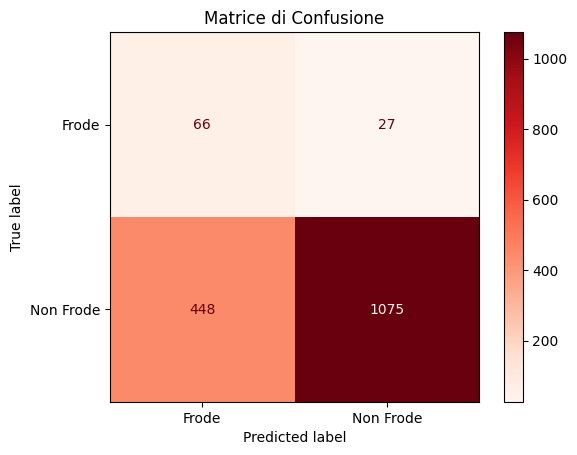

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Frode', 'Non Frode'])
disp.plot(cmap='Reds')
plt.title("Matrice di Confusione")
plt.show()


Il modello quasi mai sbaglia in eccesso nel dire che c'è una frode (alta precisione), ma qualche frode riesce ancora a sfuggire (richiamo=sensibilità non perfetta).
Nel contesto assicurativo, dipende dal costo degli errori:
Se si vuole una sensibilità più alta si può migliorare.
Ci sono pochissimi falsi positivi. Se questo è l'obiettivo allora è ok.

Ricapitolando questa seconda parte:
1. Altro modello di rete neurale convoluzionale vgg16 alternativo a ResNet18 (ResNet 18 è del 2015, vgg16 è del 2014)
vgg16 ha circa 138 milioni di parametri, mentre ResNet18 "solo" 11 milioni circa.
La struttura del primo è di 16 strati, quella del secondo è di 18 strati ma con connessioni residuali. ResNet è più profondo, ma vgg16 è più semplice e interpretabile. ResNet18 è fra i primi 5 per l'accuratezza ed è anche più leggero e veloce. Il Fine-tuning è più facile per vgg16, mentre ResNet18 è più semplice per il deep transfer learning.
2. Immagini caricate con ImageDataGenerator con ridimensionamento e normalizzazione
3. Si sono estratti dei vettori di caratteritiche con VGG16 pre-addestrata (ImageNet), senza strato pienamente connesso (include_top=False)
4. Sovracampionamento (solo training set), con applicazione di SMOTE. Si è creato una sorta di dato bootstrappato sull'insieme di training sovracampionato con la tecnica SMOTE in pratica
5. Per la visualizzazione si è usato t-SNE sul train sovracampionato per visualizzazione in 2D colorato per Frode/Non Frode (0 = rosso, 1 = blu)
6. ACP utilizzata per classificazione con 10 componenti su X_test_features quindi ho trasformato anche i dati di test
7. Classificazione con regressione logistica su dati ACP
8. Matrice di confusione

Modello con alta precisione: se segnala una frode, probabilmente lo è davvero.
Richiamo (sensibilità) discreta: riesce a cogliere il 71% delle frodi.
L'ACP + Logistica ha dato risultati buoni, ma migliorabili.



SMOTE (Synthetic Minority Over-sampling Technique)
SMOTE è una tecnica di sovracampionamento intelligente usata per affrontare dataset sbilanciati (molte non frodi, poche frodi come in questo caso).
A differenza del classico sovracampionamento che duplica i dati, SMOTE prende un punto minoritario (es. frode) Trova i suoi k vicini più vicini (di solito il default è uguale a 5). Crea nuovi punti sintetici interpolando tra il punto originale e i suoi vicini.

In questo modo i nuovi esempi non sono duplicati, ma realistici e la distribuzione della classe minoritaria si espande nel suo spazio.
Meglio sempre usarlo dopo l'estrazione delle caratteristiche perché altrimenti non funziona bene per dati categorici puri. In pratica, applicando vgg16 abbiamo ottenuto dei numeri e lo spazio risultante creato è denso e continuo e quindi adatto per SMOTE.


t-SNE (t-Distributed Stochastic Neighbor Embedding) è una tecnica di riduzione dimensionale usata principalmente per visualizzare dati ad alta dimensionalità in 2D o 3D.
È particolarmente utile quando si hanno tanti feature (es. immagini, testo, reti neurali) e si vuol vedere come si distribuiscono nel loro spazio, magari per capire se ci sono gruppi o separazioni visive tra le classi.

Calcola la similarità tra ogni coppia di punti nel dataset originale ad alta dimensione
Cerca di mantenere quelle relazioni (soprattutto quelle locali: i vicini) in uno spazio più piccolo (a 2D o 3D)
Proietta i punti in modo da preservare i “cluster locali”

Il trucco di t-SNE è il seguente: usa una distribuzione t di Student (da cui il nome) per modellare le distanze nel nuovo spazio e questa evita che i punti lontani “si schiaccino” tutti insieme.

In questo caso serve a vedere come i dati sono strutturati in 2D e a fare un'analisi di cluster eventuale (frode o non frode). NON SI UTILIZZA PER LA CLASSIFICAZIONE!! ECCO PERCHE' HO UTILIZZATO L'ACP PER LA CLASSIFICAZIONE

Hai usato VGG16 per estrarre feature numeriche dalle immagini → dataset con molte dimensioni (es. 512 o 2048)